<h2>LSTM Wandb Stocks</h2>

<h3>Objetivos</h3>

O objetivo desse notebook é testar o efeito do tamanho do dataset na predição do BTC

<h4>Material e Métodos</h4>

Para testar 5, 10, 20,30, 40, 50 e 60 dias de timeperiod

In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [2]:
import tensorflow as tf

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [3]:
#@Libraries for Stocks
from yahoo_fin.stock_info import get_data
from datetime import datetime
from matplotlib import rcParams

#@Libraries Basics
from time import time
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
import os
import math
import random

#@Libraries Wandb 
import wandb
from wandb.keras import WandbCallback
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

#@Libraries Normalization
from sklearn.preprocessing import MinMaxScaler

#@ Libraries Tensor Flow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner
from keras_tuner.tuners import RandomSearch,BayesianOptimization
from keras.utils import plot_model

print("Libraries loaded!!")

Libraries loaded!!


<h3>Setup Jupyter Lab</h3>

In [4]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#@ Settings Notebook
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suprime as mensagens do tensor flow

In [5]:
#@ Settings Notebook
warnings.filterwarnings('ignore')

In [6]:
START_DATE = dt.datetime(2018,1,1)

END_DATE = dt.datetime(2023,1,22)

dataset = get_data('BTC-USD', 
                   start_date=START_DATE, 
                   end_date=END_DATE, 
                   index_as_date = True, 
                   interval="1d")

dataset = dataset.dropna()

dataset_total = dataset.iloc[:,3:4].dropna()

dataset_total.head(3)

,close
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000


In [7]:
dataset_values = dataset_total.values 

training_dataset_len = math.ceil(len(dataset_values)* 0.8) # 80% training

mms = MinMaxScaler(feature_range=(0,1)) # range for to scale (0,1)

scaled_dataset = mms.fit_transform(dataset_values.reshape(-1,1))  # normalized dataset and reshape(-1,1)

training_dataset = scaled_dataset[0: training_dataset_len, :]

In [8]:
qt_days = 60

In [9]:
X_train = []
y_train = []

for i in range(qt_days, len(training_dataset)):
    X_train.append(training_dataset[i-qt_days:i, 0])
    y_train.append(training_dataset[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
test_dataset = scaled_dataset[training_dataset_len-qt_days: , : ]

print(f"O comprimento do teste é: {len(test_dataset)}\n")

x_test = []

y_test = dataset_values[training_dataset_len:]

for i in range(qt_days, len(test_dataset)):
    x_test.append(test_dataset[i-qt_days:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print("Dados de teste para o modelo\n", x_test.shape)

O comprimento do teste é: 429

Dados de teste para o modelo
 (369, 60, 1)


In [11]:
# # Visualizando os dados x(t) e y(t+1) que vão entrar no modelo

# for entrada, saida in zip(X_train[0:2], y_train[0:2]):
#     print(f"\n## Aqui estamos trabalhando com base de prediçao de {qt_days} dias ##\n")
#     print(entrada, "<------>", saida)

In [12]:
(X_train.shape[1],1)

(60, 1)

In [13]:
# Definindo as entradas do modelo LSTM 

quantidade_dias = X_train.shape[1]

quantidade_features = X_train.shape[2]

input_shape = (quantidade_dias, quantidade_features)

print("\n# Input Shape\n", input_shape)

print("\n# Quantidade de dias base de treinamento:\n", quantidade_dias)

print("\n# Quantidade de features:\n", quantidade_features)


# Input Shape
 (60, 1)

# Quantidade de dias base de treinamento:
 60

# Quantidade de features:
 1


<h3>Hyperparametrization using Wandb</h3>

In [14]:
parametrization = wandb.init(
    project='dataset-size',
    config={
        "learning_rate": random.uniform(0.01,0.001),
        "loss_function": "mean_squared_error",
        "architecture": "LSTM",
        "dataset":"BTC-USD",
        "lookback":"60d",
        'experiment':'effect-size-ds',
        'date_range':'2018-2023',
        'size-dataset':'5y',
        "layer_1": 50,
        "activation_1": "tanh",
        "dropout": 0.1,
        "layer_2": 50,
        "layer_3": 50,
        "layer_4": 1,
        "epoch": 100,
        "batch_size": 64
    })

config = wandb.config

wandb: Currently logged in as: sal-souzasa. Use `wandb login --relogin` to force relogin


In [15]:
# X_train.shape[1]

In [16]:
model = keras.Sequential()
    
model.add(LSTM(units = config.layer_1, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(Dropout(config.dropout))

model.add(LSTM(units = config.layer_2, return_sequences = True))
model.add(Dropout(config.dropout))

model.add(LSTM(units = config.layer_3))
model.add(Dropout(config.dropout))
    
model.add(Dense(units=config.layer_4, activation= config.activation_1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

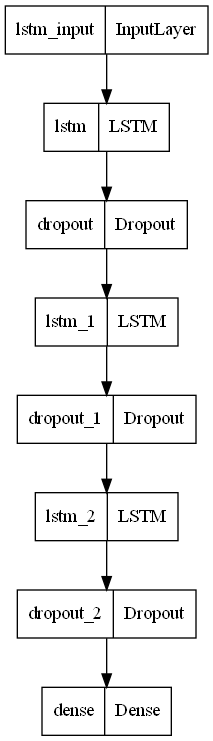

In [18]:
plot_model(model)

In [19]:
# compile the model

optimizer = tf.keras.optimizers.Adam(config.learning_rate) 

model.compile(optimizer, config.loss_function, metrics=['mae'])

# model.compile(optimizer=config.optimizer,
#               loss=config.loss
#               )

In [20]:
# WandbMetricsLogger will log train and validation metrics to wandb
# WandbModelCheckpoint will upload model checkpoints to wandb

history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=config.epoch,
                    batch_size=config.batch_size,
                    validation_data=(x_test, y_test),
                    callbacks=[WandbCallback()]
                   )

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 0.0235 - mae: 0.0967

INFO:tensorflow:Assets written to: D:\Projects\RNNcrypto\notebooks\wandb\run-20230916_171819-si6lb4zz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\RNNcrypto\notebooks\wandb\run-20230916_171819-si6lb4zz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\RNNcrypto\notebooks\wandb\run-20230916_171819-si6lb4zz\files\model-best)... Done. 0.0s


23/23 [==============================] - 77s 3s/step - loss: 0.0235 - mae: 0.0967 - val_loss: 818289408.0000 - val_mae: 26904.5039
Epoch 2/100
23/23 [==============================] - 7s 291ms/step - loss: 0.0028 - mae: 0.0374 - val_loss: 818293248.0000 - val_mae: 26904.5801
Epoch 3/100
23/23 [==============================] - 7s 318ms/step - loss: 0.0019 - mae: 0.0277 - val_loss: 818293504.0000 - val_mae: 26904.5859
Epoch 4/100
23/23 [==============================] - 7s 301ms/step - loss: 0.0017 - mae: 0.0241 - val_loss: 818294720.0000 - val_mae: 26904.6074
Epoch 5/100
23/23 [==============================] - 7s 304ms/step - loss: 0.0016 - mae: 0.0232 - val_loss: 818293504.0000 - val_mae: 26904.5859
Epoch 6/100
23/23 [==============================] - 7s 311ms/step - loss: 0.0014 - mae: 0.0222 - val_loss: 818294720.0000 - val_mae: 26904.6035
Epoch 7/100
23/23 [==============================] - 7s 302ms/step - loss: 0.0014 - mae: 0.0221 - val_loss: 818292544.0000 - val_mae: 26904.5684

In [21]:
print(history.history.keys)

<built-in method keys of dict object at 0x0000022AD3EBD000>


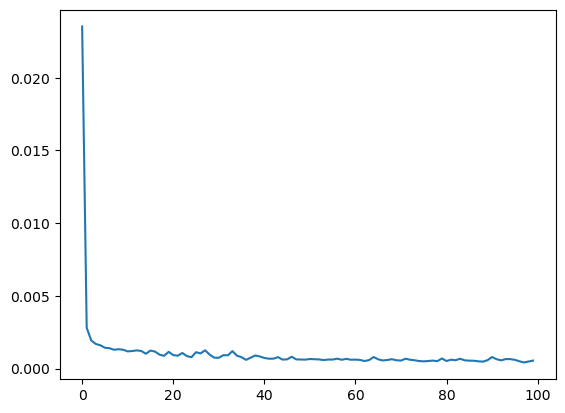

In [22]:
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'])
plt.show()

<h3>Evaluate the model</h3>

In [23]:
predictions = model.predict(x_test)

predictions.shape

12/12 [==============================] - 3s 61ms/step


(369, 1)

In [24]:
predictions = mms.inverse_transform(predictions)

In [25]:
# rmse = np.sqrt(np.mean(predictions - y_test)**2)

# print(f"RMSE: {rmse}")

In [26]:
# loss, accuracy = model.evaluate(x_test, y_test)

# print('Test Error Rate: ', round((1 - accuracy) * 100, 2))

# # With wandb.log, we can easily pass in metrics as key-value pairs.

# wandb.log({'Test Error Rate': round((1 - accuracy) * 100, 2)})

In [27]:
predictions = model.predict(x_test)
predictions = mms.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(f"RMSE: {rmse}")

from sklearn.metrics import mean_absolute_percentage_error
mape = (mean_absolute_percentage_error(y_test, predictions)*100)
print(f"MAPE: {mape}")
wandb.log({'RSME': rmse, 'MAPE' : mape})

12/12 [==============================] - 1s 54ms/step
RMSE: 265.5432519266599
MAPE: 2.93405450094036


In [28]:
# wandb.log({'RSME': rmse})

In [29]:
#@ finish process
parametrization.finish()

MAPE,▁
RSME,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▆█▅▆▇▅▅▇█▅▆██▆▆▆▇▅▇▇▆▆▆█▆█▆█▇▇█▅▇▇▇█▆▇▇
val_mae,▁▇█▅▆▇▅▆▇█▅▇██▆▇▆▇▅▇▇▇▆▆█▆█▆█▇▇▇▅▇▇▇█▆▇▇
MAPE,2.93405
RSME,265.54325
best_epoch,0
best_val_loss,818289408.0


<h3>End</h3>

In [30]:
data = dataset_total.filter(['close'])

train = data[:training_dataset_len]

In [31]:
validation = data[training_dataset_len:]

In [32]:
validation.count

<bound method DataFrame.count of                    close
2022-01-19  41744.328125
2022-01-20  40680.417969
2022-01-21  36457.316406
2022-01-22  35030.250000
2022-01-23  36276.804688
...                  ...
2023-01-18  20688.781250
2023-01-19  21086.792969
2023-01-20  22676.552734
2023-01-21  22777.625000
2023-01-22  22720.416016

[369 rows x 1 columns]>

In [33]:
predictions.shape

(369, 1)

In [34]:
validation['predictions'] = predictions

In [35]:
train.count

<bound method DataFrame.count of                    close
2018-01-01  13657.200195
2018-01-02  14982.099609
2018-01-03  15201.000000
2018-01-04  15599.200195
2018-01-05  17429.500000
...                  ...
2022-01-14  43099.699219
2022-01-15  43177.398438
2022-01-16  43113.878906
2022-01-17  42250.550781
2022-01-18  42375.632812

[1479 rows x 1 columns]>

In [36]:
validation.count

<bound method DataFrame.count of                    close   predictions
2022-01-19  41744.328125  42166.085938
2022-01-20  40680.417969  41649.042969
2022-01-21  36457.316406  40684.335938
2022-01-22  35030.250000  37375.718750
2022-01-23  36276.804688  35192.628906
...                  ...           ...
2023-01-18  20688.781250  20743.341797
2023-01-19  21086.792969  20376.324219
2023-01-20  22676.552734  20338.359375
2023-01-21  22777.625000  21347.136719
2023-01-22  22720.416016  22289.728516

[369 rows x 2 columns]>

In [37]:
validation.to_csv(f"D:/Projects/RNNcrypto/dados_tcc/size_effect/5_years/validation_{qt_days}_2018_2023_{config.learning_rate}.csv")

In [38]:
train.to_csv(f"D:/Projects/RNNcrypto/dados_tcc/size_effect/5_years/train_{qt_days}_2018_2023_{config.learning_rate}.csv")

In [39]:
len(dataset_total)-30

1818

In [40]:
len(train)

1479

In [41]:
len(validation)

369

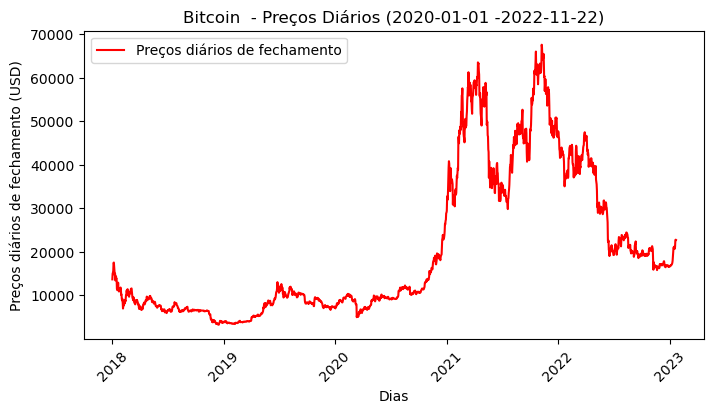

In [42]:
figure, axes = plt.subplots(figsize=(8,4))
axes.xaxis_date()

axes.plot(dataset_total['close'], label='Preços diários de fechamento', color='red')

plt.legend(loc='best')
plt.xlabel('Dias')
plt.xticks(rotation=45)
plt.ylabel('Preços diários de fechamento (USD)')
plt.title('Bitcoin  - Preços Diários (2020-01-01 -2022-11-22)')
plt.show()

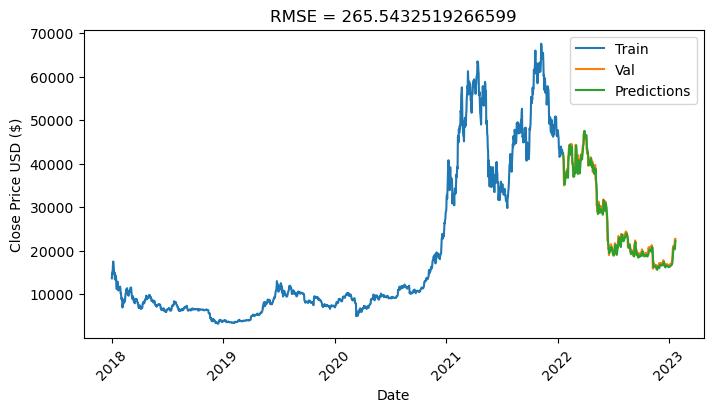

In [43]:
figure, axes = plt.subplots(figsize=(8,4))
axes.xaxis_date()

axes.plot(train)
axes.plot(validation[['close', 'predictions']])

plt.title(f"RMSE = {rmse}")
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks(rotation=45)
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.savefig("")
plt.show()

In [44]:
import numpy as np # linear algebra
import IPython.display as ipd


beep = np.sin(2*np.pi*400*np.arange(10000*2)/10000)
ipd.Audio(beep, rate=10000, autoplay=True)

In [45]:
# from IPython.lib.display import Audio
# import numpy as np

# framerate = 4410
# play_time_seconds = 3

# t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
# audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
# Audio(audio_data, rate=framerate, autoplay=True)